# This notebook contains code to compare KMeans Clustering and Hierarchical clustering to determine which is more effective and some initial concepts on Cluster Drift

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
df_raw = pd.read_csv("data/Sample_Superstore_v2.csv",
                     encoding='latin1')

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [4]:
df_raw.describe(include=['O'])

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name
count,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994
unique,5009,1237,1334,4,793,793,3,1,531,49,4,1862,3,17,1850
top,CA-2017-100111,9/5/2016,12/16/2015,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope
freq,14,38,35,5968,37,37,5191,9994,915,2001,3203,19,6026,1523,48


In [5]:
df_key_fields = df_raw[['Customer ID', 'Sub-Category', 'Sales']].copy()

In [6]:
df_cust_sales = df_key_fields.pivot_table(values = 'Sales',
                                          columns = 'Sub-Category',
                                          aggfunc=np.sum,
                                          index='Customer ID')

In [7]:
df_cust_sales.fillna(0, inplace=True)

In [8]:
df_cust_sales.iloc[:,1:] = df_cust_sales.iloc[:,1:].applymap(lambda x: np.log(x+1))

In [9]:
df_cust_sales.fillna(0.0, inplace=True)

In [10]:
df_for_pca = df_cust_sales.copy()

## Clustering by Employing K Means

In [11]:
pca = PCA()
df_pca = pca.fit_transform(df_for_pca)
np.cumsum(pca.explained_variance_ratio_)

array([0.99945   , 0.99953693, 0.99959492, 0.99964698, 0.99969419,
       0.99973759, 0.99977795, 0.99981226, 0.99984433, 0.99987236,
       0.99989738, 0.99991997, 0.99994054, 0.99995892, 0.99997657,
       0.99999202, 1.        ])

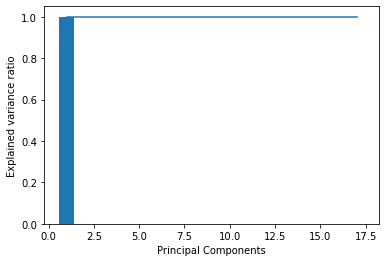

In [12]:
plt.bar(range(1,df_pca.shape[1]+1),pca.explained_variance_ratio_,align='center')
plt.step(range(1,df_pca.shape[1]+1 ), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal Components')

plt.show()

In [17]:
#Find number of components based variance ratio explained 
n_components = 2

In [18]:
pca_components = PCA(n_components = n_components)

In [19]:
pca_arr = pca_components.fit_transform(df_for_pca)

C:\Users\wengz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


19


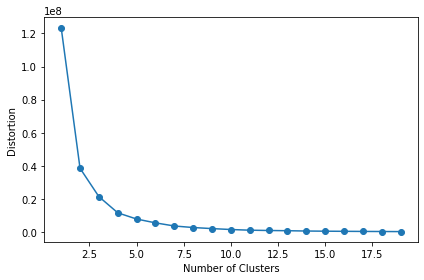

In [21]:
distortions = []
for i in range(1,20):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(pca_arr)
    distortions.append(km.inertia_)

print(len(distortions))
plt.plot(range(1,len(distortions)+1), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

In [22]:
km_final = KMeans(n_clusters=4,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
results = km_final.fit_predict(pca_arr)

In [30]:
unique_elements, counts_elements = np.unique(results, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[  0   1   2   3]
 [553  51  16 173]]


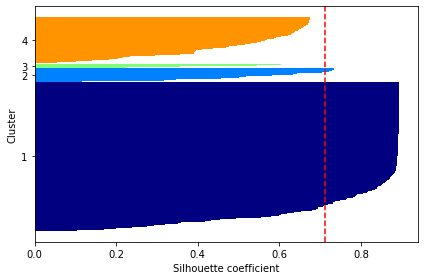

In [26]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(results)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(pca_arr, results, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[results == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('figures/10_04.png', dpi=300)
plt.show()

## Clustering by employing Hierarchical Clustering

In [31]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

In [32]:
row_clusters = linkage(df_for_pca.values, 
                       method='ward', 
                       metric='euclidean')

In [37]:
len(np.unique(row_clusters))

2376